In [1]:
import os
import numpy as np
import glob
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pickle

from shutil import copyfile
from PIL import Image
from IPython import display 

%matplotlib inline

Below, I've taken 5 pictures different we will use as baseline to prepare the preparation

In [2]:
images_list = ["1b44d22643830cd4f23c9deadb0bd499fb392fb2cd9526d81547d93077d983df", 
               "01d44a26f6680c42ba94c9bc6339228579a95d0e2695b149b7cc0c9592b21baf", 
               "00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552",
               "538b7673d507014d83af238876e03617396b70fe27f525f8205a4a96900fbb8e",
               "4193474b2f1c72f735b13633b219d9cabdd43c21d9c2bb4dfc4809f104ba4c06"]

Here, we will add all functions required for the notebook. This is just to load them easily when we restart the Kernel.

In [2]:
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
        
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

def is_back_and_white(img):
    a = np.array_equiv(image[:, :, 0], image[:, :, 1])
    b = np.array_equiv(image[:, :, 1], image[:, :, 2])
    return (a and b)

def boost_contrast(img):
    mini = img.min()
    maxi = img.max()
    return (img-mini)*(255/(maxi-mini))

def add_seuillage(img, level=100):
    img = (img-level)*(255/(255-(2*level)))
    img = np.clip(img, 0, 255)
    return img

def prepare_image_init(image):
    if not is_back_and_white(image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray = cv2.bitwise_not(gray)
        gray = boost_contrast(gray)
        gray = add_seuillage(gray, level=50)
    else:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray = boost_contrast(gray)
        gray = add_seuillage(gray, level=0)
    return gray

def prepare_image_final(image):
    if not is_back_and_white(image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray = cv2.bitwise_not(gray)
        gray = boost_contrast(gray)
        gray = add_seuillage(gray, level=50)
    else:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        if gray.mean() > 150:
            gray = cv2.bitwise_not(gray)
        gray = boost_contrast(gray)
        gray = add_seuillage(gray, level=0)
    return gray

# Exploration

### Merge masks

To start, we will merge masks. This can be done by adding images matrices as they are without intersection and "binary"

In [31]:
# for folder in glob.glob("images/train/*"):
#     folder_name = os.path.basename(folder)
#     for idx, mask_url in enumerate(glob.glob("images/train/" + folder_name + "/masks/*.png")):
#         mask_img = Image.open(mask_url)
#         mask_img = np.asarray(mask_img)
#         if idx == 0:
#             full_mask = mask_img
#         else:
#             full_mask = full_mask + mask_img
#     full_mask = Image.fromarray(full_mask)
#     full_mask.save("images/train/" + folder_name + "/masks/full_mask.png")

Now, every images, will have a mask called "full_mask.png". We can now display both images and masks

### find out what we are looking for

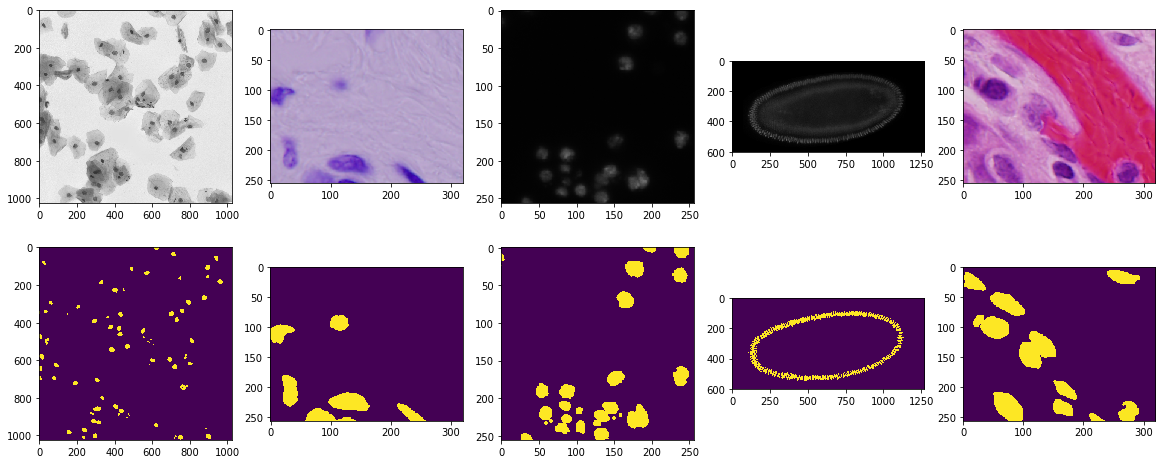

In [5]:
f, axarr = plt.subplots(2, 5, figsize=(20,8))
for idx, img_id in enumerate(images_list):
    mask_url = "images/train/" + img_id + "/masks/full_mask.png"
    image_url = "images/train/" + img_id + "/images/" + img_id + ".png"
    mask_img = Image.open(mask_url)
    image_img = Image.open(image_url)
    axarr[0, idx].imshow(np.asarray(image_img))
    axarr[1, idx].imshow(np.asarray(mask_img))
plt.show()

Now, we know that we must discover all "cells" either pink or white (depending on the process used to get them)

### Check sizes

Prior any resizing, let's take a look at images sizes. We can see above that for all 3 images, we have the same height. Maybe wa can find a constant dimensions

In [10]:
# name, width, height = [], [], []
# for idx, img in enumerate(glob.glob("images/train/*/images/*.png")):
#     pil_im = Image.open(img)
#     name.append(os.path.basename(img))
#     width.append(pil_im.size[0])
#     height.append(pil_im.size[1])

# df = pd.DataFrame({"image": name, "width" : width, "height" : height})
# df.to_csv("dataset/dimensions_train.csv", index=False)

In [3]:
df=pd.read_csv("dataset/dimensions_train.csv")

In [4]:
df["height"].value_counts()
# df["height"].hist(bins=100)

256     446
520      92
360      91
1024     16
512      13
603       6
260       5
1040      1
Name: height, dtype: int64

In [5]:
df["width"].value_counts()

256     334
320     112
696      92
360      91
1024     16
640      13
1272      6
347       5
1388      1
Name: width, dtype: int64

<font style="font-weight:bold" color='red'>Attention</font>: Images are evaluated on IoU (see <a href="https://www.kaggle.com/c/data-science-bowl-2018#evaluation">link</a>). As a result, if we resize images, pixel index will change and don't match expected one from evaluation. A a result, we cannot do it. We will have to check for models taking all size of images.

# Preparation

### Augmentation on images

As we saw previously, we must detect "white" or "pink" dots. To help the model to learn, we can probably look how to play with contrast to ease the learning.

First, let's check if an image is black and white or color

True
False
True
True
False


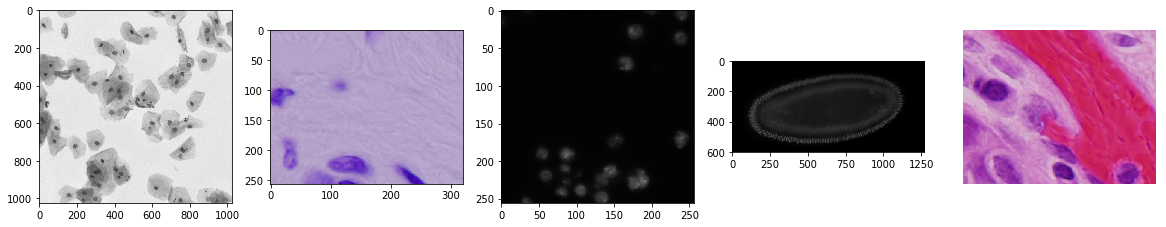

In [8]:
size = 5
f, axarr = plt.subplots(1, size, figsize=(20,8))
for idx, img_id in enumerate(images_list):
    image_url = "images/train/" + img_id + "/images/" + img_id + ".png"
    image = cv2.imread(image_url)
    a = np.array_equiv(image[:, :, 0], image[:, :, 1])
    b = np.array_equiv(image[:, :, 1], image[:, :, 2])
    print(a and b)
    
    axarr[idx].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.plot()

now we are able to detect colored image. For those ones, let's convert them to black and white but first. Let see how we can improve contrast for our model

[]

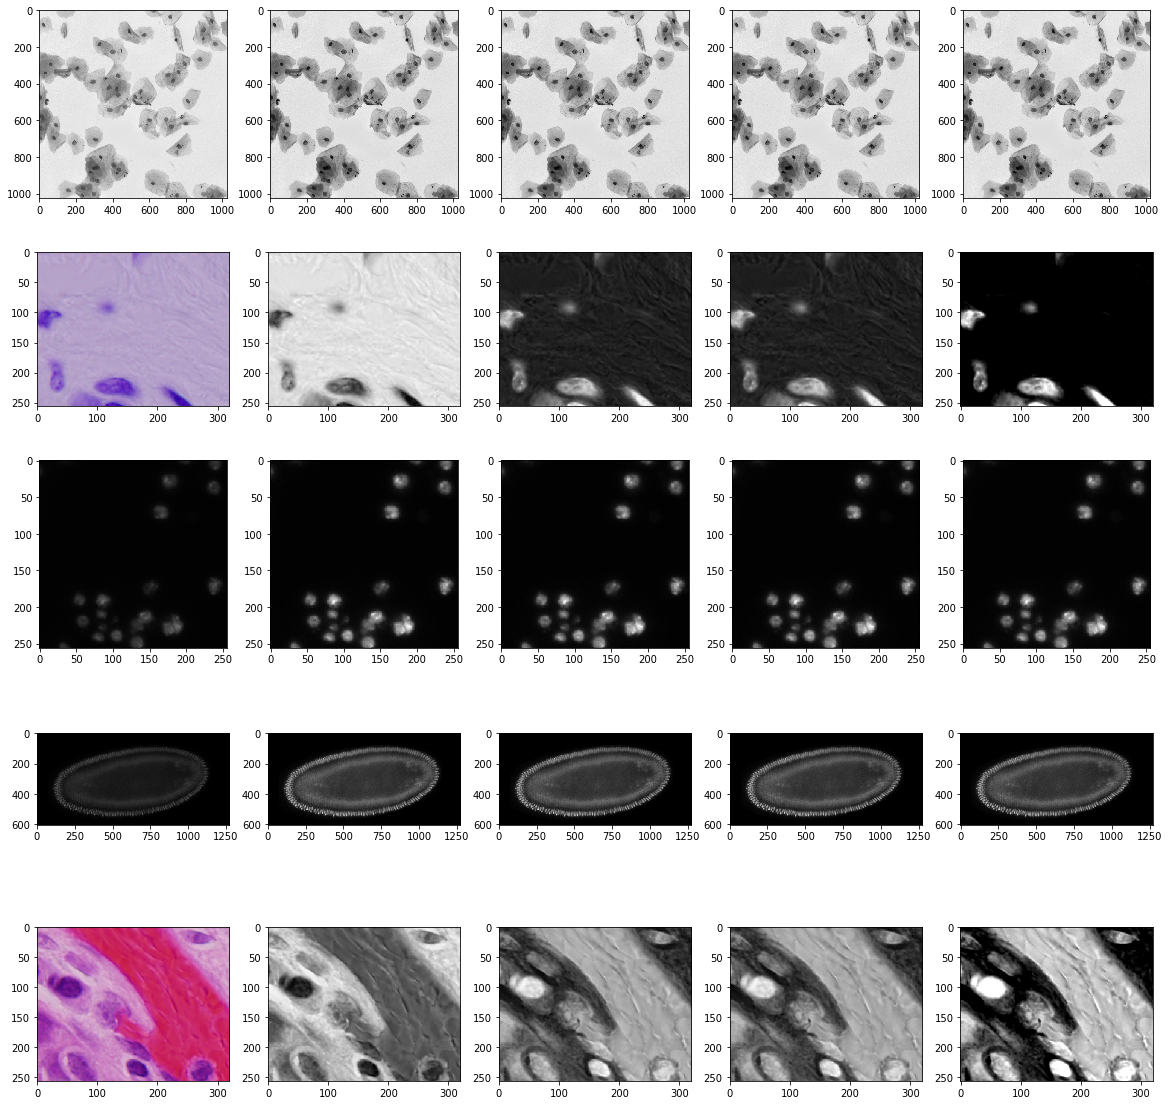

In [7]:
size = 5
steps = 5
f, axarr = plt.subplots(size, steps, figsize=(20,20))
for idx, img_id in enumerate(images_list):
    image_url = "images/train/" + img_id + "/images/" + img_id + ".png"
    image = cv2.imread(image_url)
    if not is_back_and_white(image):
#         cv2.imwrite('img/step0.png', image)
        axarr[idx, 0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)         # convertion en gris
#         cv2.imwrite('img/step1.png', gray)
        axarr[idx, 1].imshow(gray, cmap='gray')

        gray = cv2.bitwise_not(gray)                           # inversion noir et blanc
#         cv2.imwrite('img/step2.png', gray)
        axarr[idx, 2].imshow(gray, cmap='gray')

        gray = boost_contrast(gray)
#         cv2.imwrite('img/step3.png', gray)
        axarr[idx, 3].imshow(gray, cmap='gray')

        gray = add_seuillage(gray, level=50)
#         cv2.imwrite('img/step4.png', gray)
        axarr[idx, 4].imshow(gray, cmap='gray')
    else:
        axarr[idx, 0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        axarr[idx, 1].imshow(gray, cmap='gray')
        axarr[idx, 2].imshow(gray, cmap='gray')
        gray = boost_contrast(gray)
        axarr[idx, 3].imshow(gray, cmap='gray')
        gray = add_seuillage(gray, level=0)
        axarr[idx, 4].imshow(gray, cmap='gray')
plt.plot()

We can see that the filter Black and White is not strong enougth as some pictures are already reversed. We will now try to detect either or not we must convert or not the picture

### Handle reversed B&W images

We can try to use the average value of pixels. To find the proper threshold, let's look at distribution after preparation

In [16]:
# df=pd.read_csv("dataset/dimensions_train.csv")
# mean_list = []

# for folder in glob.glob("images/train/*"):
#     folder_name = os.path.basename(folder)
#     img_name = folder_name
#     img_path = os.path.join(folder, "images", img_name+".png")
    
#     image = cv2.imread(img_path)
#     prepared_image = prepare_image_init(image)      # at this step, we have no idea about the threshold so we use the initial expected function
#     mean_list.append(prepared_image.mean())

# df["mean_color"] = mean_list
# df.to_csv("dataset/dimensions_train.csv", index=False)

[]

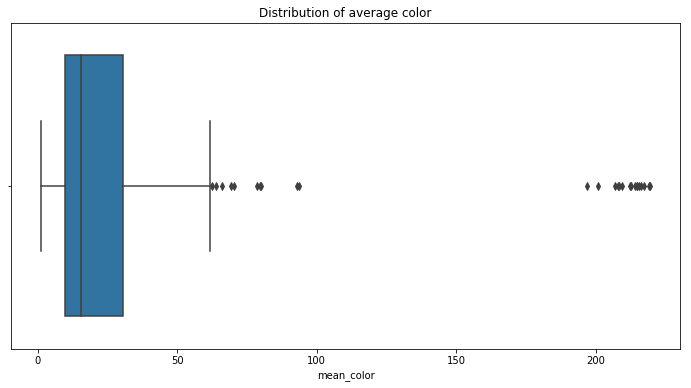

In [81]:
df=pd.read_csv("dataset/dimensions_train.csv")

plt.figure(figsize=(12, 6))
sns.boxplot(x=df["mean_color"])
plt.title("Distribution of average color")
plt.plot()

As we could imagine, reverse images are far from the main bucket. We can easily split if mean > 150. This check has been added in *function prepare_image_final*

Just before to export all images, let's take a final look to the result

[]

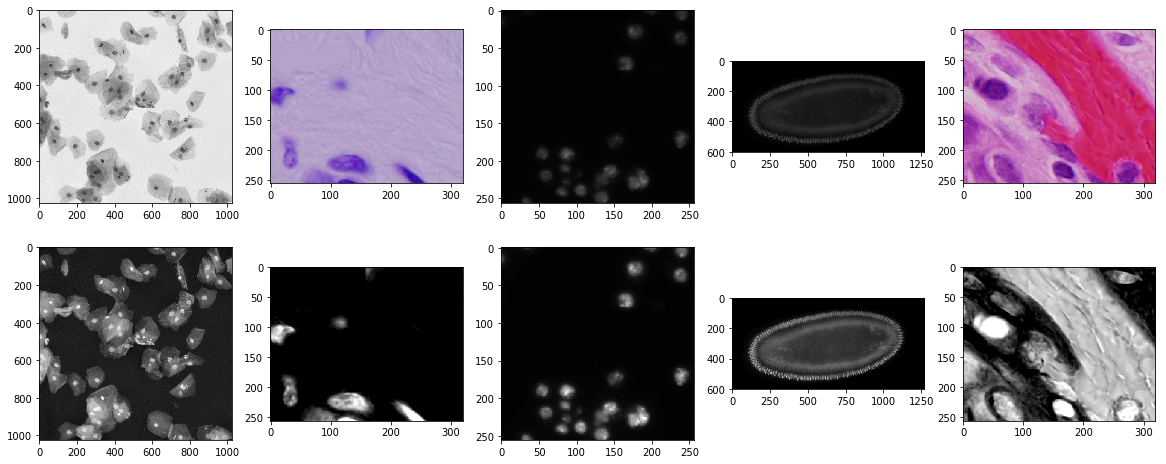

In [25]:
size = 5
f, axarr = plt.subplots(2, size, figsize=(20,8))
for idx, img_id in enumerate(images_list):
    image_url = "images/train/" + img_id + "/images/" + img_id + ".png"
    image = cv2.imread(image_url)
    gray = prepare_image_final(image)
    axarr[0, idx].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axarr[1, idx].imshow(gray, cmap='gray')
plt.plot()

For now it's not so bad. Maybe the model will learn bad thing but we should firt try it ! This will be done under another notebook. For now, let's just create our cleaned dataset of images/ merged filters

### Canny Edge Detection

In order to ease the model to detect cells border, we can take a look to other function "impove" shapes. First, let's look at the edge detection

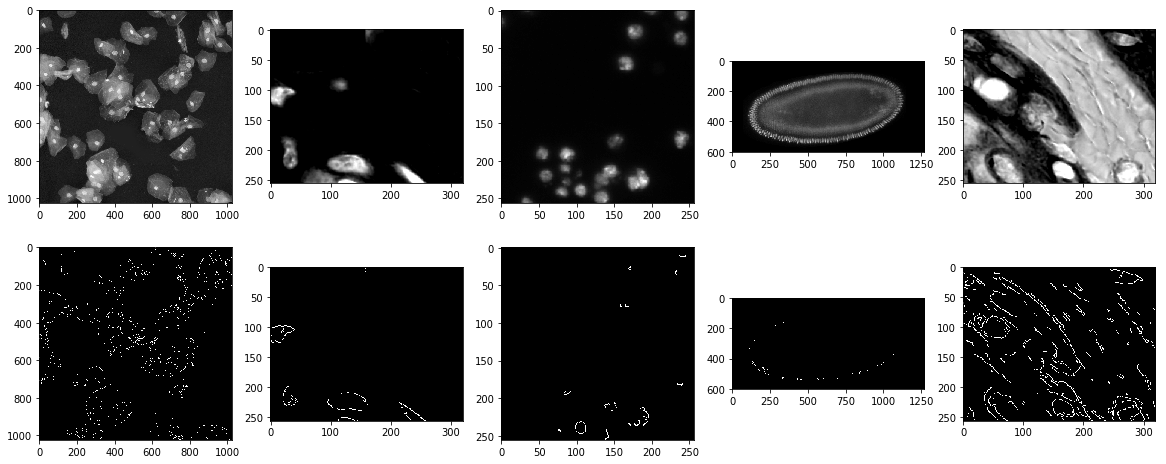

In [42]:
size = 5
f, axarr = plt.subplots(2, size, figsize=(20,8))
for idx, img_id in enumerate(images_list):
    image_url = "images/train/" + img_id + "/images/" + img_id + ".png"
    image = cv2.imread(image_url)
    gray = prepare_image_final(image)
#     gray = np.expand_dims(gray, 3)
    edges = cv2.Canny(image, 100, 150)
    axarr[0, idx].imshow(gray, cmap='gray')
    axarr[1, idx].imshow(edges, cmap='gray')
plt.show()

We can keep an eye on this solution and based on result, we may add it.

### Laplacian

To detect shapes, we can also try to detect fast variation of colors.

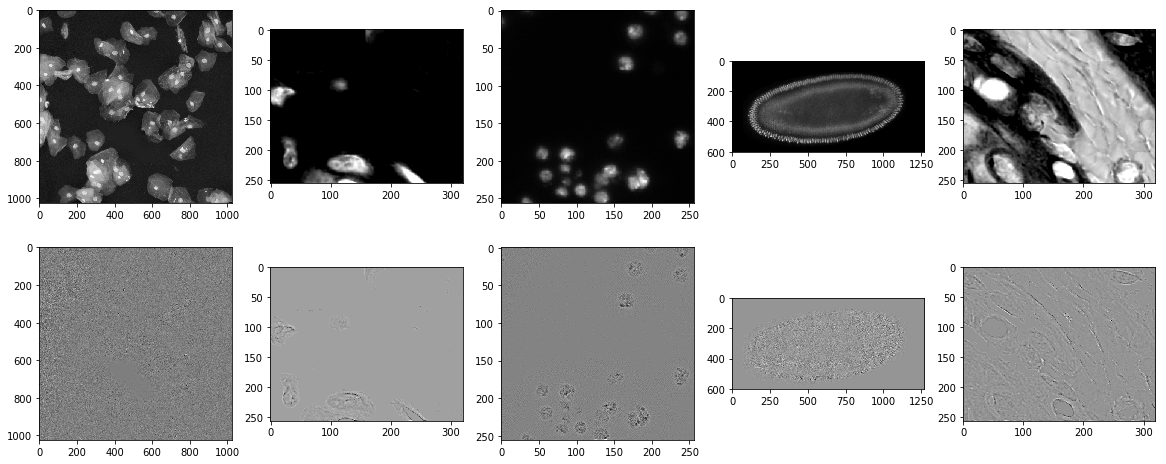

In [44]:
size = 5
f, axarr = plt.subplots(2, size, figsize=(20,8))
for idx, img_id in enumerate(images_list):
    image_url = "images/train/" + img_id + "/images/" + img_id + ".png"
    image = cv2.imread(image_url)
    gray = prepare_image_final(image)
    lap = cv2.Laplacian(gray, cv2.CV_64F)
    axarr[0, idx].imshow(gray, cmap='gray')
    axarr[1, idx].imshow(lap, cmap='gray')
plt.show()

This one is clearly more noisy. We cannot use it as is but Adaptative thresholding can probably do it with better results

### Adaptive Thresholding

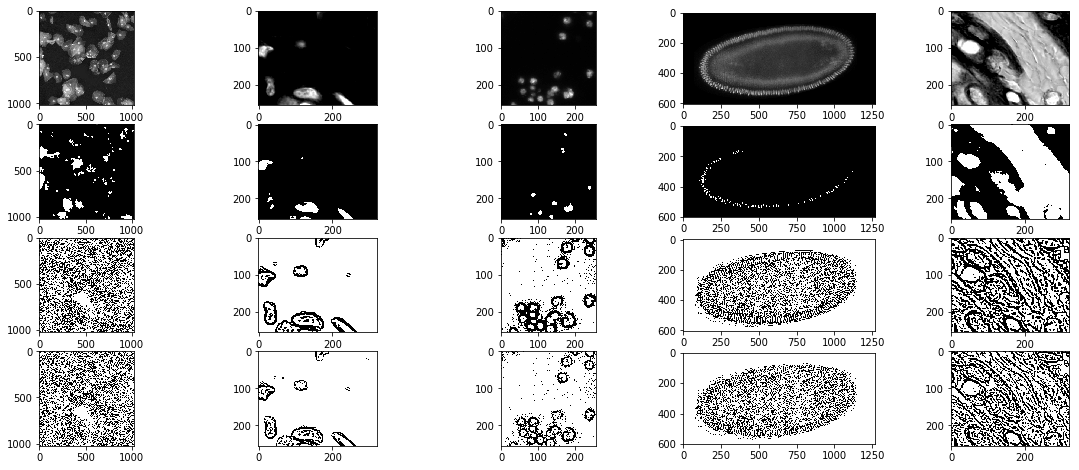

In [77]:
size = 5
f, axarr = plt.subplots(4, size, figsize=(20,8))
for idx, img_id in enumerate(images_list):
    image_url = "images/train/" + img_id + "/images/" + img_id + ".png"
    image = cv2.imread(image_url)
    gray = prepare_image_final(image).astype(np.uint8)
    img = cv2.medianBlur(gray, 5)
    ret,th1 = cv2.threshold(img,127, 255, cv2.THRESH_BINARY)
    th2 = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
    th3 = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    
    titles = ['Original Image', 'Global Thresholding (v = 127)',
            'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
    
    axarr[0, idx].imshow(gray, cmap='gray')
    axarr[1, idx].imshow(th1, cmap='gray')
    axarr[2, idx].imshow(th2, cmap='gray')
    axarr[3, idx].imshow(th3, cmap='gray')
plt.show()

### Otsu's Binarization

Finally, we can take a look a Binarization to set to one pixel above a certain value.

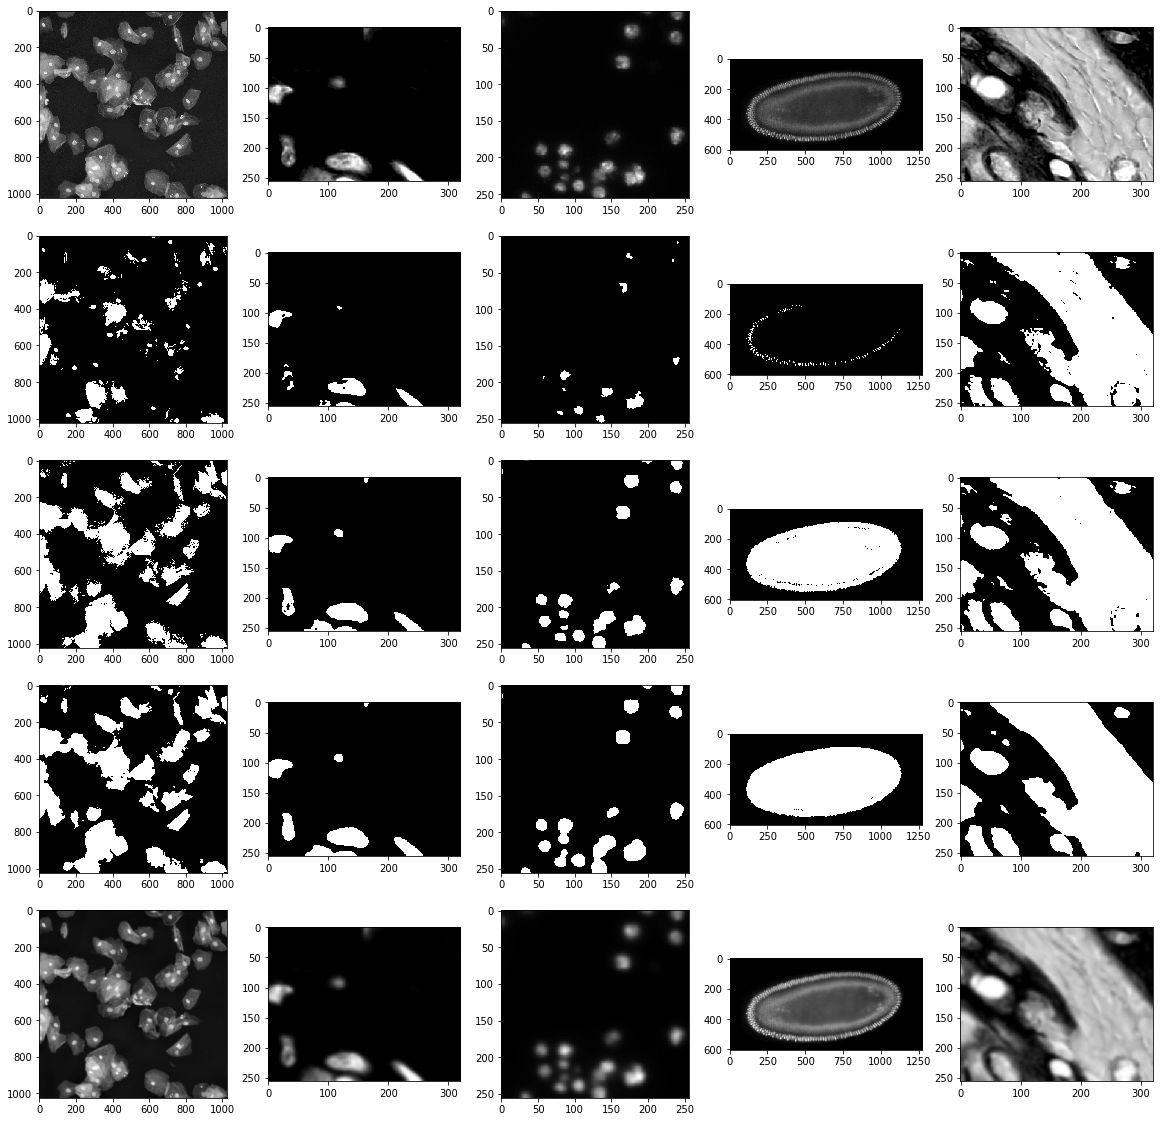

In [79]:
size = 5
f, axarr = plt.subplots(5, size, figsize=(20,20))
for idx, img_id in enumerate(images_list):
    image_url = "images/train/" + img_id + "/images/" + img_id + ".png"
    image = cv2.imread(image_url)
    gray = prepare_image_final(image).astype(np.uint8)
    
    ret1,th1 = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    ret2,th2 = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    blur = cv2.GaussianBlur(gray,(15,15),0)
    ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    titles = ['Original Image', 'Global Thresholding (v = 127)',
            'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
    
    axarr[0, idx].imshow(gray, cmap='gray')
    axarr[1, idx].imshow(th1, cmap='gray')
    axarr[2, idx].imshow(th2, cmap='gray')
    axarr[3, idx].imshow(th3, cmap='gray')
    axarr[4, idx].imshow(blur, cmap='gray')
plt.show()

This method is too brutal but we may use it on the output from model to improve masks

# Export for models

Now, we know how to prepare our images, we can generate the dataset to train the model. First, let's move pictures / masks in a new folder with pre-processing

In [27]:
for folder in glob.glob("images/train/*"):
    folder_name = os.path.basename(folder)
    img_name = folder_name
    img_path = os.path.join(folder, "images", img_name+".png")
    mask_path = os.path.join(folder, "masks", "full_mask.png")
    
    image = cv2.imread(img_path)
    prepared_image = prepare_image_final(image)
    
    cv2.imwrite(os.path.join("images/prepared/train/images", img_name+".png"), prepared_image)
#     copyfile(mask_path, os.path.join("images/prepared/train/masks", img_name+".png"))

### Resizing

For the model, we are going to use we need an image of 572x572. To do so, we will incease size of original images with balck and for bigger ones, they are not a lot, we will rescale them and maintain the ratio. The complement will be done also with black. A the same time, we will create X and Y matrices and save thme for future use.

In [4]:
W, H, D = 512, 512, 1

X = np.zeros((670, H, W, D), dtype=np.uint8)
y = np.zeros((670, H, W, 1), dtype=np.uint8)
dimensions = []
for idx, path in enumerate(glob.glob("images/prepared/train/images/*.png")):
    img_name = os.path.basename(path)
    img_path = path
    mask_path = os.path.join("images/prepared/train/masks", img_name)
    image = cv2.imread(img_path)
    mask = cv2.imread(mask_path)
    
    height, width, channels = image.shape
    dimensions.append([height, width])
    new_img = np.zeros((H, W, D), dtype=np.uint8)
    new_mask = np.zeros((H, W, 1), dtype=np.uint8)

    if height <= H and width <= W:
        new_img[0: height, 0: width, 0] =  image[:, :, 0]
        new_mask[0: height, 0: width, 0] =  mask[:, :, 0]
    else:
        resize_factor = W/max(width, height)
        image = cv2.resize(image, None, fx=resize_factor, fy=resize_factor, interpolation = cv2.INTER_NEAREST)
        mask = cv2.resize(mask, None, fx=resize_factor, fy=resize_factor, interpolation = cv2.INTER_NEAREST)
        height, width, channels = image.shape
        new_img[0: height, 0: width, 0] =  image[:, :, 0]
        new_mask[0: height, 0: width, 0] =  mask[:, :, 0]
        
    X[idx, :, :, :] = new_img
    y[idx, :, :, :] = new_mask

np.savez_compressed('datas/dataset.npz', X=X, y=y)
save_obj(dimensions, "datas/dimensions")

For memory reasons, we will keep values as uint8 for now. The conversion to a 0-1 scale will be done during the training inside the model

[]

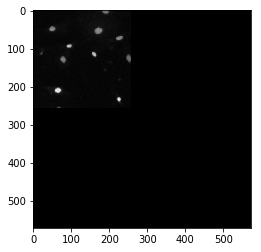

In [28]:
plt.imshow(X[152], cmap='gray')
plt.savefig("img/resizing.png")
plt.plot()